In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from datetime import timedelta

In [37]:
import collections

class Vocabulary(object):
    START_TOKEN = "<s>"
    END_TOKEN = "</s>"
    UNK_TOKEN = "<unk>"

    def __init__(self, tokens, size=None):
        self.unigram_counts = collections.Counter(tokens)
        self.num_unigrams = sum(self.unigram_counts.values())
        # leave space for "<s>", "</s>", and "<unk>"
        top_counts = self.unigram_counts.most_common(None if size is None else (size - 3))
        vocab = ([self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN] +
                 [w for w,c in top_counts])

        # Assign an id to each word, by frequency
        self.id_to_word = dict(enumerate(vocab))
        self.word_to_id = {v:k for k,v in self.id_to_word.items()}
        self.size = len(self.id_to_word)
        if size is not None:
            assert(self.size <= size)

        # For convenience
        self.wordset = set(self.word_to_id.keys())

        # Store special IDs
        self.START_ID = self.word_to_id[self.START_TOKEN]
        self.END_ID = self.word_to_id[self.END_TOKEN]
        self.UNK_ID = self.word_to_id[self.UNK_TOKEN]

    def words_to_ids(self, words):
        return [self.word_to_id.get(w, self.UNK_ID) for w in words]

    def ids_to_words(self, ids):
        return [self.id_to_word[i] for i in ids]

    def sentence_to_ids(self, words):
        return [self.START_ID] + self.words_to_ids(words) + [self.END_ID]

    def ordered_words(self):
        """Return a list of words, ordered by id."""
        return self.ids_to_words(range(self.size))


In [7]:
def clean(sentence):
    return sentence.lower().split()

# Load in Articles

In [3]:
df = pd.read_excel('all_season.xlsx')
df.head()

,date,name,news,team
0,2017-11-17,Bryan Bulaga,('The Green Bay Press-Gazette suggests the Pac...,Packers
1,2017-11-17,Philip Rivers,('Philip Rivers (concussion) has been cleared ...,Chargers
2,2017-11-17,Ezekiel Ansah,('The Detroit Free Press considers contract-ye...,Lions
3,2017-11-17,Ryan Grant,('Ryan Grant (concussion) is questionable for ...,Redskins
4,2017-11-17,Ronnie Stanley,('Ravens LT Ronnie Stanley (concussion) is lis...,Ravens


In [10]:
#Split sentences into words
df.iloc[0,2]

'(\'Anquan Boldin believes Zach Zenner can take a step forward in 2017.\', \'\\n             "Whenever you have a young guy like that who’s able to play every down, that’s big," Boldin said. "I saw him personally mature over the year, and he grabbed the coaches’ confidence. They weren’t shy about putting him in there. When they did put him in there, he responded well." Zenner was the unquestioned lead back by the end of the season, but the healthy returns of Ameer Abdullah and Theo Riddick are sure to push Zenner back down the depth chart. It is also possible the Lions add another big back in free agency or the draft. Despite a great finish to the season, Zenner is likely to open 2017 near the bottom of the depth chart.\\n        \')'

In [4]:
players = df.name.unique()

In [5]:
len(players)

1681

In [6]:
df.shape

(5665, 4)

In [8]:
df['news_list'] = df['news'].apply(lambda x: clean(x))

In [9]:
df.head()

,date,name,news,team,news_list
0,2017-11-17,Bryan Bulaga,('The Green Bay Press-Gazette suggests the Pac...,Packers,"[('the, green, bay, press-gazette, suggests, t..."
1,2017-11-17,Philip Rivers,('Philip Rivers (concussion) has been cleared ...,Chargers,"[('philip, rivers, (concussion), has, been, cl..."
2,2017-11-17,Ezekiel Ansah,('The Detroit Free Press considers contract-ye...,Lions,"[('the, detroit, free, press, considers, contr..."
3,2017-11-17,Ryan Grant,('Ryan Grant (concussion) is questionable for ...,Redskins,"[('ryan, grant, (concussion), is, questionable..."
4,2017-11-17,Ronnie Stanley,('Ravens LT Ronnie Stanley (concussion) is lis...,Ravens,"[('ravens, lt, ronnie, stanley, (concussion), ..."


In [10]:
df.dtypes

date         datetime64[ns]
name                 object
news                 object
team                 object
news_list            object
dtype: object

In [60]:
#df['date'] = ['2017 ' + x if x[:3] in ('Feb', 'Jan') else '2016 ' + x for x in df['date']]

In [66]:
#df['date'] = df['date'].apply(lambda x: pd.datetime.strptime(x, '%Y %b %d - %H:%M %p'))

In [92]:
df.tail()

,date,name,news,team,news_list
550,2017-01-01,Chip Kelly,"('49ers fired HC Chip Kelly.', ""\n ...",Free Agent,"[('49ers, fired, hc, chip, kelly.',, ""\n, espn..."
551,2017-01-01,Brandon Coleman,"(""Brandon Coleman caught 1-of-3 targets for ei...",Saints,"[(""brandon, coleman, caught, 1-of-3, targets, ..."
552,2017-01-01,Tyrell Williams,('Tyrell Williams caught 6-of-7 targets for 70...,Chargers,"[('tyrell, williams, caught, 6-of-7, targets, ..."
553,2017-01-01,Brandin Cooks,"(""Brandin Cooks caught 3-of-6 targets for 19 y...",Patriots,"[(""brandin, cooks, caught, 3-of-6, targets, fo..."
554,2017-01-01,Ronnie Hillman,('Ronnie Hillman rushed seven times for 41 yar...,Free Agent,"[('ronnie, hillman, rushed, seven, times, for,..."


In [11]:
#Match up scores with articles
scores = pd.read_csv('fantasy_points_data.csv', parse_dates= True)
scores.head()

,Player,Team,Position,Year,Week,Points
0,Drew Brees,NO,QB,2016,1,37.7
1,Andrew Luck,IND,QB,2016,1,37.4
2,Alex Smith,KC,QB,2016,1,33.7
3,Jameis Winston,TB,QB,2016,1,30.4
4,Matthew Stafford,DET,QB,2016,1,29.5


In [16]:
scores.dtypes

Player       object
Team         object
Position     object
Year          int64
Week          int64
Points      float64
dtype: object

In [12]:
scores.shape

(7161, 6)

In [17]:
scores['Week'].value_counts()

2     583
3     563
4     555
7     545
1     536
6     524
10    493
5     490
9     478
8     459
16    294
12    287
15    286
17    285
14    273
13    269
11    241
Name: Week, dtype: int64

In [18]:
scores['Year'].value_counts()

2016    4560
2017    2601
Name: Year, dtype: int64

In [13]:
start_of_season = {2016:pd.datetime.strptime('2016-09-08', '%Y-%m-%d'),
                  2017:pd.datetime.strptime('2017-09-08', '%Y-%m-%d')}

In [14]:
start_of_season2016 = pd.datetime.strptime('2016-09-08', '%Y-%m-%d')
start_of_season2017 = pd.datetime.strptime('2017-09-08', '%Y-%m-%d')

In [19]:
scores['max_date'] = scores.apply(lambda x: start_of_season[x['Year']] + timedelta(weeks = x['Week']), axis=1)
scores['min_date'] = scores.apply(lambda x: start_of_season[x['Year']] + timedelta(weeks = x['Week'] - 1), axis=1)

In [20]:
scores.tail()

,Player,Team,Position,Year,Week,Points,max_date,min_date
7156,Michael Hoomanawanui,NO,TE,2017,10,0.4,2017-11-17,2017-11-10
7157,Tyler Kroft,CIN,TE,2017,10,0.4,2017-11-17,2017-11-10
7158,Antonio Gates,LAC,TE,2017,10,0.3,2017-11-17,2017-11-10
7159,David Njoku,CLE,TE,2017,10,0.3,2017-11-17,2017-11-10
7160,A.J. Derby,DEN,TE,2017,10,0.2,2017-11-17,2017-11-10


In [21]:
combined = scores.merge(df, how='inner', left_on='Player', right_on='name')

In [22]:
combined.dtypes

Player               object
Team                 object
Position             object
Year                  int64
Week                  int64
Points              float64
max_date     datetime64[ns]
min_date     datetime64[ns]
date         datetime64[ns]
name                 object
news                 object
team                 object
news_list            object
dtype: object

In [23]:
combined.shape

(48527, 13)

In [70]:
combined.iloc[50:100]

,index,Player,Team,Position,Year,Week,Points,max_date,min_date,date,name,news,team,news_list
50,1898,Cam Newton,CAR,QB,2016,15,20.0,2016-12-22,2016-12-15,2016-12-19,Cam Newton,"(""Cam Newton (shoulder) is active for Monday n...",Panthers,"[(""cam, newton, (shoulder), is, active, for, m..."
51,2005,Cam Newton,CAR,QB,2017,5,26.2,2017-10-13,2017-10-06,2017-10-12,Cam Newton,"(""Cam Newton completed 28-of-52 passes for 238...",Panthers,"[(""cam, newton, completed, 28-of-52, passes, f..."
52,2089,Cam Newton,CAR,QB,2017,10,35.7,2017-11-17,2017-11-10,2017-11-13,Cam Newton,"(""Cam Newton completed 21-of-35 passes for 254...",Panthers,"[(""cam, newton, completed, 21-of-35, passes, f..."
53,2182,Marcus Mariota,TEN,QB,2016,7,16.7,2016-10-27,2016-10-20,2016-10-27,Marcus Mariota,"(""Marcus Mariota completed 18-of-22 passes for...",Titans,"[(""marcus, mariota, completed, 18-of-22, passe..."
54,2193,Marcus Mariota,TEN,QB,2016,8,19.9,2016-11-03,2016-10-27,2016-10-27,Marcus Mariota,"(""Marcus Mariota completed 18-of-22 passes for...",Titans,"[(""marcus, mariota, completed, 18-of-22, passe..."
55,2316,Marcus Mariota,TEN,QB,2017,6,14.2,2017-10-20,2017-10-13,2017-10-17,Marcus Mariota,"(""Marcus Mariota (hamstring) escaped Monday ni...",Titans,"[(""marcus, mariota, (hamstring), escaped, mond..."
56,2317,Marcus Mariota,TEN,QB,2017,6,14.2,2017-10-20,2017-10-13,2017-10-16,Marcus Mariota,"(""Marcus Mariota completed 23-of-32 passes for...",Titans,"[(""marcus, mariota, completed, 23-of-32, passe..."
57,2318,Marcus Mariota,TEN,QB,2017,6,14.2,2017-10-20,2017-10-13,2017-10-16,Marcus Mariota,('Marcus Mariota (hamstring) is active and sta...,Titans,"[('marcus, mariota, (hamstring), is, active, a..."
58,2319,Marcus Mariota,TEN,QB,2017,6,14.2,2017-10-20,2017-10-13,2017-10-14,Marcus Mariota,"(""Marcus Mariota (hamstring) is questionable f...",Titans,"[(""marcus, mariota, (hamstring), is, questiona..."
59,2348,Marcus Mariota,TEN,QB,2017,10,17.7,2017-11-17,2017-11-10,2017-11-16,Marcus Mariota,"(""Marcus Mariota completed 22-of-33 passes for...",Titans,"[(""marcus, mariota, completed, 22-of-33, passe..."


In [24]:
combined = combined[(combined['date'] <= combined['max_date']) & 
                    (combined['date'] >= combined['min_date'])]

In [55]:
combined.shape

(1137, 13)

In [69]:
combined.reset_index(inplace=True)

In [26]:
combined.to_excel('combined.xlsx')

In [5]:
#Normalize scores

In [6]:
#Split into train/test

In [38]:
token_feed = (word for news in combined['news_list'] for word in news)

vocab = Vocabulary(token_feed)

In [39]:
vocab.size

9372

In [40]:
for word, count in vocab.unigram_counts.most_common(10):
    print("\"%s\": %d" % (word, count))

"the": 4820
"a": 2576
"in": 2278
"to": 1754
"for": 1585
"week": 1364
"and": 1277
"on": 1092
"of": 963
"was": 959


In [52]:
encoded = pd.DataFrame([collections.Counter(vocab.words_to_ids(x)) for x in combined['news_list']], 
                       columns = range(vocab.size))

In [53]:
encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,9362,9363,9364,9365,9366,9367,9368,9369,9370,9371
0,NaN,NaN,NaN,9.0,4.0,3.0,2.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,9.0,4.0,3.0,2.0,3.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,3.0,1.0,NaN,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,9.0,4.0,4.0,1.0,3.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,10.0,3.0,5.0,5.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
encoded.fillna(value= 0, inplace=True)

In [54]:
encoded.shape

(1137, 9372)

In [51]:
np.ndarray(vocab.size)

array([  1.22649551e-311,   1.22649962e-311,   0.00000000e+000, ...,
         0.00000000e+000,   0.00000000e+000,   0.00000000e+000])

In [57]:
from sklearn.model_selection import train_test_split

In [71]:
X_train, X_test, y_train, y_test = train_test_split(encoded, combined['Points'], test_size = 0.5)

In [89]:
model = naive_bayes.GaussianNB()

In [73]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9362,9363,9364,9365,9366,9367,9368,9369,9370,9371
905,0.0,0.0,0.0,2.0,1.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
965,0.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,0.0,0.0,0.0,4.0,3.0,4.0,1.0,2.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
527,0.0,0.0,0.0,3.0,1.0,2.0,0.0,2.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,0.0,5.0,6.0,2.0,2.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [74]:
y_train.head()

905     4.1
965     0.5
139    15.9
527     9.1
302    24.0
Name: Points, dtype: float64

In [90]:
model.fit(X_train, np.asarray(y_train, dtype=np.float32))

ValueError: Unknown label type: (array([  0.1       ,   0.2       ,   0.30000001,   0.40000001,
         0.5       ,   0.60000002,   0.69999999,   0.80000001,
         0.89999998,   1.        ,   1.10000002,   1.20000005,
         1.29999995,   1.39999998,   1.5       ,   1.60000002,
         1.70000005,   1.79999995,   1.89999998,   2.        ,
         2.0999999 ,   2.20000005,   2.29999995,   2.4000001 ,
         2.5       ,   2.5999999 ,   2.70000005,   2.79999995,
         2.9000001 ,   3.        ,   3.0999999 ,   3.20000005,
         3.29999995,   3.4000001 ,   3.5       ,   3.5999999 ,
         3.70000005,   3.79999995,   3.9000001 ,   4.0999999 ,
         4.19999981,   4.30000019,   4.4000001 ,   4.5       ,
         4.5999999 ,   4.69999981,   4.80000019,   4.9000001 ,
         5.        ,   5.0999999 ,   5.19999981,   5.30000019,
         5.4000001 ,   5.5       ,   5.5999999 ,   5.69999981,
         5.80000019,   5.9000001 ,   6.        ,   6.0999999 ,
         6.19999981,   6.30000019,   6.4000001 ,   6.5999999 ,
         6.69999981,   6.80000019,   6.9000001 ,   7.        ,
         7.0999999 ,   7.19999981,   7.30000019,   7.4000001 ,
         7.5999999 ,   7.69999981,   7.80000019,   7.9000001 ,
         8.        ,   8.10000038,   8.19999981,   8.30000019,
         8.39999962,   8.5       ,   8.60000038,   8.69999981,
         8.80000019,   8.89999962,   9.        ,   9.10000038,
         9.19999981,   9.30000019,   9.5       ,   9.60000038,
         9.69999981,   9.80000019,   9.89999962,  10.10000038,
        10.19999981,  10.30000019,  10.5       ,  10.60000038,
        10.69999981,  10.80000019,  10.89999962,  11.        ,
        11.10000038,  11.19999981,  11.30000019,  11.39999962,
        11.60000038,  11.69999981,  11.80000019,  11.89999962,
        12.        ,  12.19999981,  12.5       ,  12.60000038,
        12.69999981,  12.80000019,  13.        ,  13.19999981,
        13.39999962,  13.5       ,  13.60000038,  13.69999981,
        13.80000019,  13.89999962,  14.        ,  14.10000038,
        14.19999981,  14.30000019,  14.5       ,  14.60000038,
        14.69999981,  14.80000019,  14.89999962,  15.        ,
        15.19999981,  15.30000019,  15.39999962,  15.69999981,
        15.80000019,  15.89999962,  16.        ,  16.20000076,
        16.39999962,  16.5       ,  16.70000076,  16.79999924,
        17.        ,  17.29999924,  17.39999962,  18.        ,
        18.20000076,  18.29999924,  18.39999962,  18.70000076,
        18.79999924,  19.        ,  19.10000038,  19.20000076,
        19.29999924,  19.39999962,  19.5       ,  19.89999962,
        20.        ,  20.10000038,  20.39999962,  20.5       ,
        20.60000038,  20.70000076,  20.89999962,  21.        ,
        21.20000076,  21.39999962,  21.5       ,  21.60000038,
        21.89999962,  22.29999924,  22.5       ,  22.60000038,
        22.70000076,  22.89999962,  23.10000038,  23.29999924,
        23.60000038,  23.79999924,  23.89999962,  24.        ,
        24.39999962,  24.79999924,  25.20000076,  25.29999924,
        25.39999962,  25.5       ,  26.10000038,  26.20000076,
        26.29999924,  26.5       ,  26.79999924,  27.        ,
        27.39999962,  28.29999924,  29.70000076,  29.79999924,
        30.39999962,  35.70000076], dtype=float32),)

In [84]:
model.score(X_test, np.asarray(y_test, dtype='|S6'))

0.01054481546572935

In [85]:
?model.score()

In [86]:
preds = model.predict(X_test)

In [88]:
preds

array([b'1.0', b'1.0', b'1.7', b'1.0', b'1.0', b'1.0', b'1.0', b'4.7',
       b'4.7', b'1.0', b'1.0', b'1.0', b'1.7', b'1.0', b'4.7', b'1.0',
       b'1.7', b'1.7', b'4.7', b'1.0', b'1.0', b'1.0', b'1.0', b'1.0',
       b'1.0', b'1.7', b'4.7', b'1.0', b'1.0', b'1.0', b'1.7', b'1.7',
       b'1.0', b'4.7', b'1.7', b'1.7', b'1.0', b'1.0', b'1.0', b'4.7',
       b'4.7', b'4.7', b'4.7', b'1.0', b'1.0', b'1.0', b'1.0', b'1.0',
       b'1.0', b'1.0', b'1.7', b'1.7', b'1.0', b'1.0', b'1.0', b'1.0',
       b'4.7', b'1.0', b'1.0', b'1.0', b'1.7', b'1.0', b'1.0', b'1.0',
       b'4.7', b'1.0', b'1.0', b'1.7', b'1.0', b'1.7', b'1.0', b'1.0',
       b'1.0', b'1.0', b'1.0', b'1.0', b'1.0', b'1.0', b'4.7', b'1.0',
       b'4.7', b'1.7', b'1.7', b'1.0', b'4.7', b'1.7', b'1.0', b'1.0',
       b'1.0', b'1.7', b'1.0', b'1.0', b'1.0', b'4.7', b'1.0', b'4.7',
       b'1.0', b'1.0', b'1.7', b'1.7', b'1.0', b'1.0', b'1.0', b'4.7',
       b'1.0', b'1.0', b'1.0', b'1.7', b'1.7', b'1.7', b'1.0', b'1.7',
      

In [95]:
from sklearn.ensemble import RandomForestRegressor

In [96]:
RFC = RandomForestRegressor()

In [100]:
X_test.shape

(569, 9372)

In [ ]:
y_t

In [101]:
RFC.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [102]:
RFC.score(X_test, y_test)

0.19312228804024167

In [171]:
from sklearn.svm import LinearSVR
SVM = LinearSVR()
SVM.fit(X_train, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [172]:
np.mean(np.square(SVM.predict(X_test) - np.array(y_test, dtype = np.float32)))**.5

6.6121678642519628

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [107]:
SVM.score(X_test, y_test)

0.11890349683970702

In [108]:
SVM.coef_

array([ 0.        ,  0.        ,  0.        , ..., -0.02113526,
       -0.02113526, -0.1213843 ])

In [109]:
np.max(SVM.coef_)

2.2255536873169426

In [147]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    #feature_names = feature_names)
    #return feature_names(top_coefficients)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names(top_coefficients), rotation=60, ha='right')
    plt.show()

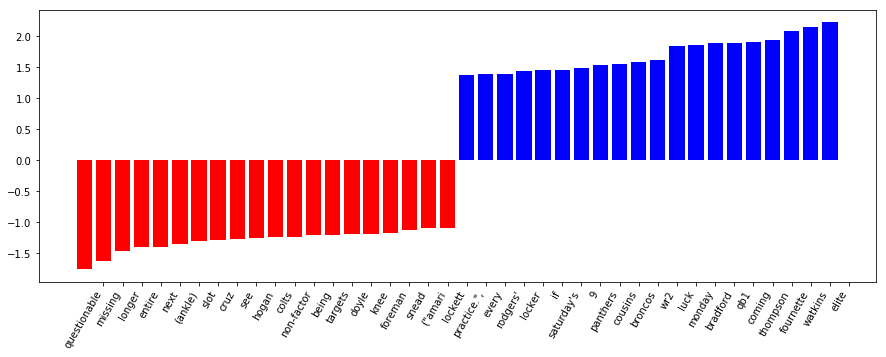

TypeError: 'NoneType' object is not iterable

In [149]:
vocab.ids_to_words(plot_coefficients(SVM, vocab.ids_to_words))

In [146]:
plot_coefficients(SVM, vocab.ids_to_words)

TypeError: 'numpy.ndarray' object is not callable

In [128]:
vocab.ids_to_words([15])

['he']

In [117]:
cv = CountVectorizer()

In [116]:
from sklearn.feature_extraction.text import CountVectorizer

In [119]:
cv.get_feature_names()

In [ ]:
cv.fit(combined[''])

In [163]:
np.diff(SVM.predict(X_test), np.array(y_test, dtype = np.float32))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [157]:
type(SVM.predict(X_test))

numpy.ndarray

In [170]:
np.mean(np.square(SVM.predict(X_test) - np.array(y_test, dtype = np.float32)))**.5

6.6121936208041561

In [173]:
len(X_test)

569